In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

In [2]:
# torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def train_myNNcv(model, X, y, chunk_size, batch_size, learning_rate=1e-3):
    losses=[]
    ce_loss = nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
    model.train()
    ds = Gen_Dataset(Xtrain, ytrain)
    data_loader = DataLoader(ds, batch_size=batch_size)
    for X, y in data_loader:
        X = X.float()
        if X.shape[0] < 10:
            continue
        y = y.float().view(-1, 1)
        opt.zero_grad()
        out = model(X)
        loss = ce_loss(out, y)
        losses.append(loss.item())
        loss.backward()
        opt.step()
    return losses

def test_myNNcv(model, X, y):
    model.eval()
    with torch.no_grad():
        out = model(X)
        ypred = torch.round(out)
        y = y.numpy()
        acc = accuracy_score(ypred, y)
        TP, FP, TN, FN = 0, 0, 0, 0
        for i in range(len(ypred)):
            if ypred[i] == 1 and ytest[i] == 1:
                TP += 1
            elif ypred[i] == 1 and ytest[i] == 0:
                FP += 1
            elif ypred[i] == 0 and ytest[i] == 0:
                TN += 1    
            elif ypred[i] == 0 and ytest[i] == 1:
                FN += 1
        precision = TP/(TP + FP)
        recall = TP/(TP + FN)
        print('Accuracy, Precision, Recall: ', np.round(acc, 3), np.round(precision, 3), np.round(recall, 3))
    print('Finished all testing...')
    return acc, precision, recall

In [4]:
def train_myNN(model, file_list, chunk_size, batch_size, cols, learning_rate=1e-3):
    losses=[]
#     ce_loss = nn.BCELoss()
    ce_loss = nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
    net.train()
    for file in file_list:
        path = 'D:\\Stock Data\\' + file
        print('Training data file: ' + file)
        for df in pd.read_csv(path, chunksize=chunk_size, usecols=cols):
            if df.shape[0] < batch_size:
                continue
            Xtrain = df.drop(['labels'], axis=1)
            ytrain = df['labels']
            ds = Gen_Dataset(Xtrain, ytrain)
            data_loader = DataLoader(ds, batch_size=batch_size)
            for X, y in data_loader:
                X = X.float()
                if X.shape[0] < 10:
                    continue
                y = y.float().view(-1, 1)
                opt.zero_grad()
                out = net(X)
                loss = ce_loss(out, y)
                losses.append(loss.item())
                loss.backward()
                opt.step()
#     return losses
        print('Finished training ', file)
    print('Finished all training...')
    return losses

def train_myNN2(model, file_list, chunk_size, batch_size, cols, learning_rate=1e-3, epochs=10):
    losses=[]
#     ce_loss = nn.BCELoss()
    ce_loss = nn.BCEWithLogitsLoss()
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
    net.train()
    for file in file_list:
        path = 'D:\\Stock Data\\' + file
        print('Training data file: ' + file)
        for e in range(epochs):
            for df in pd.read_csv(path, chunksize=chunk_size, usecols=cols):
                if df.shape[0] < batch_size:
                    continue
                Xtrain = df.drop(['labels'], axis=1)
                ytrain = df['labels']
                ds = Gen_Dataset(Xtrain, ytrain)
                data_loader = DataLoader(ds, batch_size=batch_size)
                for X, y in data_loader:
                    X = X.float()
                    if X.shape[0] < 10:
                        continue
                    y = y.float().view(-1, 1)
                    opt.zero_grad()
                    out = net(X)
                    loss = ce_loss(out, y)
                    losses.append(loss.item())
                    loss.backward()
                    opt.step()
#     return losses
        print('Finished training ', file)
    print('Finished all training...')
    return losses

def test_myNN(model, file_list, cols):
    model.eval()
    for file in file_list:
        path = 'D:\\Stock Data\\' + file
        print('Testing data file: ' + file)
        df_test = pd.read_csv(path, usecols=cols)
        Xtest = torch.tensor(df_test.drop(['labels'], axis=1).values).float()
        ytest = torch.tensor(df_test['labels'].values).float()

        with torch.no_grad():
            out = model(Xtest)
            ypred = torch.round(out)
            ytest = ytest.numpy()
            acc = accuracy_score(ypred, ytest)
        TP, FP, TN, FN = 0, 0, 0, 0
        for i in range(len(ypred)):
            if ypred[i] == 1 and ytest[i] == 1:
                TP += 1
            elif ypred[i] == 1 and ytest[i] == 0:
                FP += 1
            elif ypred[i] == 0 and ytest[i] == 0:
                TN += 1    
            elif ypred[i] == 0 and ytest[i] == 1:
                FN += 1
        precision = TP/(TP + FP)
        recall = TP/(TP + FN)
        print('Accuracy, Precision, Recall: ', np.round(acc, 3), np.round(precision, 3), np.round(recall, 3))
    print('Finished all testing...')
    
class Gen_Dataset():
    def __init__(self, X, y):
        self.X = torch.tensor(X.values)
        self.y = torch.tensor(y.values)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return (self.X[i, :], self.y[i])
    
class myNN(nn.Module):
    def __init__(self):
        super(myNN, self).__init__()
        self.hidden_nodes = 64
        self.fc1 = nn.Linear(8, self.hidden_nodes)
        self.fc2 = nn.Linear(self.hidden_nodes, self.hidden_nodes)
        self.fc3 = nn.Linear(self.hidden_nodes, 1)
        
#         self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(self.hidden_nodes)
        self.batchnorm2 = nn.BatchNorm1d(self.hidden_nodes)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm2(x)
#         x = self.dropout(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

In [5]:
chunk_size = 1e4
batch_size = 128
cols = ['PAST_1y_p90', 'leverage', 'leverage_mkt', \
        'bm', 'roe', 'lag_baspread', 'lag_liquidity', 'lag_size', 'labels']

In [45]:
net = myNN()
file_list = ['data2000_train1.csv']
test_file_list = ['data2000_test1.csv']
learning_rate = 1e-4
losses = train_myNN(model=net, file_list=file_list, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate)
test_myNN(net, test_file_list, cols=cols)

Training data file: data2000_train1.csv
Finished training  data2000_train1.csv
Finished all training...
Testing data file: data2000_test1.csv
Accuracy, Precision, Recall:  0.885 0.148 0.005
Finished all testing...


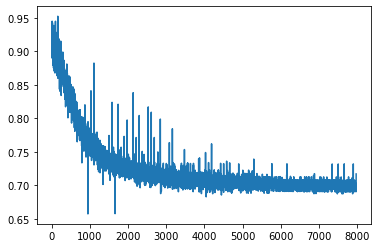

In [46]:
plt.plot(losses)

In [51]:
net = myNN()
file_list = ['data2000_under.csv']
test_file_list = ['data2000_test1.csv']
learning_rate = 1e-3
losses = train_myNN(model=net, file_list=file_list, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate)
test_myNN(net, test_file_list, cols=cols)

Training data file: data2000_under.csv
Finished training  data2000_under.csv
Finished all training...
Testing data file: data2000_test1.csv
Accuracy, Precision, Recall:  0.879 0.183 0.022
Finished all testing...


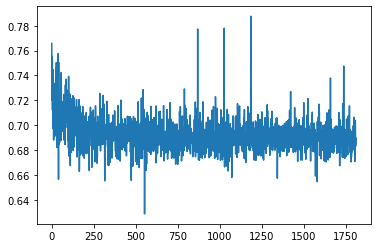

In [52]:
plt.plot(losses)

In [57]:
#training with full set of undersampled data, excluding potential outliers (financial crisis, COVID19, etc)
file_list2 = ['data2000_under.csv', 'data2001_under.csv', 'data2002_under.csv', \
                  'data2003_under.csv', 'data2004_under.csv', 'data2005_under.csv', \
                  'data2006_under.csv', 'data2007_under.csv', 'data2008_under.csv', \
                  'data2011_under.csv', 'data2012_under.csv', 'data2013_under.csv', \
                  'data2014_under.csv', 'data2015_under.csv', 'data2016_under.csv', \
                  'data2017_under.csv', 'data2018_under.csv']
test_file_list2 = ['data2000_test1.csv', 'data2001_test1.csv', 'data2002_test1.csv', \
                          'data2003_test1.csv', 'data2004_test1.csv', 'data2005_test1.csv', \
                          'data2006_test1.csv', 'data2007_test1.csv', 'data2008_test1.csv', \
                          'data2011_test1.csv', 'data2012_test1.csv', 'data2013_test1.csv', \
                          'data2014_test1.csv', 'data2015_test1.csv', 'data2016_test1.csv', \
                          'data2017_test1.csv', 'data2018_test1.csv']

In [54]:
net = myNN()
learning_rate = 1e-3
losses = train_myNN(model=net, file_list=file_list2, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate)
test_myNN(net, test_file_list2, cols=cols)

Training data file: data2000_under.csv
Finished training  data2000_under.csv
Training data file: data2001_under.csv
Finished training  data2001_under.csv
Training data file: data2002_under.csv
Finished training  data2002_under.csv
Training data file: data2003_under.csv
Finished training  data2003_under.csv
Training data file: data2004_under.csv
Finished training  data2004_under.csv
Training data file: data2005_under.csv
Finished training  data2005_under.csv
Training data file: data2006_under.csv
Finished training  data2006_under.csv
Training data file: data2007_under.csv
Finished training  data2007_under.csv
Training data file: data2008_under.csv
Finished training  data2008_under.csv
Training data file: data2011_under.csv
Finished training  data2011_under.csv
Training data file: data2012_under.csv
Finished training  data2012_under.csv
Training data file: data2013_under.csv
Finished training  data2013_under.csv
Training data file: data2014_under.csv
Finished training  data2014_under.csv

In [74]:
#training with single year of undersampled data
file_list22 = ['data2000_under.csv', 'data2001_under.csv', 'data2002_under.csv', \
                  'data2003_under.csv', 'data2004_under.csv', 'data2005_under.csv', \
                  'data2006_under.csv', 'data2007_under.csv', 'data2008_under.csv', \
                  'data2009_under.csv', 'data2010_under.csv', \
                  'data2011_under.csv', 'data2012_under.csv', 'data2013_under.csv', \
                  'data2014_under.csv', 'data2015_under.csv', 'data2016_under.csv', \
                  'data2017_under.csv', 'data2018_under.csv', 'data2019_under.csv', \
                  'data2020_under.csv']
test_file_list22 = ['data2000_test1.csv', 'data2001_test1.csv', 'data2002_test1.csv', \
                          'data2003_test1.csv', 'data2004_test1.csv', 'data2005_test1.csv', \
                          'data2006_test1.csv', 'data2007_test1.csv', 'data2008_test1.csv', \
                          'data2009_test1.csv', 'data2010_test1.csv', \
                          'data2011_test1.csv', 'data2012_test1.csv', 'data2013_test1.csv', \
                          'data2014_test1.csv', 'data2015_test1.csv', 'data2016_test1.csv', \
                          'data2017_test1.csv', 'data2018_test1.csv', 'data2019_test1.csv', \
                          'data2020_test1.csv']

In [62]:
learning_rate = 1e-3
for i in range(len(file_list22)):
    net = myNN()
    file_list222 = [file_list22[i]]
    test_file_list222 = [test_file_list22[i]]
    losses = train_myNN(model=net, file_list=file_list222, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate)
    test_myNN(net, test_file_list222, cols=cols)

Training data file: data2000_under.csv
Finished training  data2000_under.csv
Finished all training...
Testing data file: data2000_test1.csv
Accuracy, Precision, Recall:  0.879 0.194 0.023
Finished all testing...
Training data file: data2001_under.csv
Finished training  data2001_under.csv
Finished all training...
Testing data file: data2001_test1.csv
Accuracy, Precision, Recall:  0.906 0.129 0.007
Finished all testing...
Training data file: data2002_under.csv
Finished training  data2002_under.csv
Finished all training...
Testing data file: data2002_test1.csv
Accuracy, Precision, Recall:  0.894 0.14 0.012
Finished all testing...
Training data file: data2003_under.csv
Finished training  data2003_under.csv
Finished all training...
Testing data file: data2003_test1.csv
Accuracy, Precision, Recall:  0.899 0.119 0.036
Finished all testing...
Training data file: data2004_under.csv
Finished training  data2004_under.csv
Finished all training...
Testing data file: data2004_test1.csv
Accuracy, Pre

In [71]:
#training with full set of original data, excluding potential outliers (financial crisis, COVID19, etc)
file_list3 = ['data2000_train1.csv', 'data2001_train1.csv', 'data2002_train1.csv', \
                  'data2003_train1.csv', 'data2004_train1.csv', 'data2005_train1.csv', \
                  'data2006_train1.csv', 'data2007_train1.csv', 'data2008_train1.csv', \
                  'data2011_train1.csv', 'data2012_train1.csv', 'data2013_train1.csv', \
                  'data2014_train1.csv', 'data2015_train1.csv', 'data2016_train1.csv', \
                  'data2017_train1.csv', 'data2018_train1.csv']
test_file_list3 = ['data2000_test1.csv', 'data2001_test1.csv', 'data2002_test1.csv', \
                          'data2003_test1.csv', 'data2004_test1.csv', 'data2005_test1.csv', \
                          'data2006_test1.csv', 'data2007_test1.csv', 'data2008_test1.csv', \
                          'data2011_test1.csv', 'data2012_test1.csv', 'data2013_test1.csv', \
                          'data2014_test1.csv', 'data2015_test1.csv', 'data2016_test1.csv', \
                          'data2017_test1.csv', 'data2018_test1.csv']

In [59]:
net = myNN()
learning_rate = 1e-4
losses = train_myNN(model=net, file_list=file_list3, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate)
test_myNN(net, test_file_list3, cols=cols)

Training data file: data2000_train1.csv
Finished training  data2000_train1.csv
Training data file: data2001_train1.csv
Finished training  data2001_train1.csv
Training data file: data2002_train1.csv
Finished training  data2002_train1.csv
Training data file: data2003_train1.csv
Finished training  data2003_train1.csv
Training data file: data2004_train1.csv
Finished training  data2004_train1.csv
Training data file: data2005_train1.csv
Finished training  data2005_train1.csv
Training data file: data2006_train1.csv
Finished training  data2006_train1.csv
Training data file: data2007_train1.csv
Finished training  data2007_train1.csv
Training data file: data2008_train1.csv
Finished training  data2008_train1.csv
Training data file: data2011_train1.csv
Finished training  data2011_train1.csv
Training data file: data2012_train1.csv
Finished training  data2012_train1.csv
Training data file: data2013_train1.csv
Finished training  data2013_train1.csv
Training data file: data2014_train1.csv
Finished tra

In [65]:
#training with individual year of original data
file_list33 = ['data2000_train1.csv', 'data2001_train1.csv', 'data2002_train1.csv', \
                  'data2003_train1.csv', 'data2004_train1.csv', 'data2005_train1.csv', \
                  'data2006_train1.csv', 'data2007_train1.csv', 'data2008_train1.csv', \
                  'data2009_train1.csv', 'data2010_train1.csv', \
                  'data2011_train1.csv', 'data2012_train1.csv', 'data2013_train1.csv', \
                  'data2014_train1.csv', 'data2015_train1.csv', 'data2016_train1.csv', \
                  'data2017_train1.csv', 'data2018_train1.csv', 'data2019_train1.csv', \
                  'data2020_train1.csv']
test_file_list33 = ['data2000_test1.csv', 'data2001_test1.csv', 'data2002_test1.csv', \
                          'data2003_test1.csv', 'data2004_test1.csv', 'data2005_test1.csv', \
                          'data2006_test1.csv', 'data2007_test1.csv', 'data2008_test1.csv', \
                          'data2009_test1.csv', 'data2010_test1.csv', \
                          'data2011_test1.csv', 'data2012_test1.csv', 'data2013_test1.csv', \
                          'data2014_test1.csv', 'data2015_test1.csv', 'data2016_test1.csv', \
                          'data2017_test1.csv', 'data2018_test1.csv', 'data2019_test1.csv', \
                          'data2020_test1.csv']

In [67]:
learning_rate = 1e-4
for i in range(len(file_list33)):
    net = myNN()
    file_list333 = [file_list33[i]]
    test_file_list333 = [test_file_list33[i]]
    losses = train_myNN(model=net, file_list=file_list333, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate)
    test_myNN(net, test_file_list333, cols=cols)

Training data file: data2000_train1.csv
Finished training  data2000_train1.csv
Finished all training...
Testing data file: data2000_test1.csv
Accuracy, Precision, Recall:  0.883 0.155 0.008
Finished all testing...
Training data file: data2001_train1.csv
Finished training  data2001_train1.csv
Finished all training...
Testing data file: data2001_test1.csv
Accuracy, Precision, Recall:  0.907 0.13 0.004
Finished all testing...
Training data file: data2002_train1.csv
Finished training  data2002_train1.csv
Finished all training...
Testing data file: data2002_test1.csv
Accuracy, Precision, Recall:  0.896 0.117 0.006
Finished all testing...
Training data file: data2003_train1.csv
Finished training  data2003_train1.csv
Finished all training...
Testing data file: data2003_test1.csv
Accuracy, Precision, Recall:  0.914 0.089 0.004
Finished all testing...
Training data file: data2004_train1.csv
Finished training  data2004_train1.csv
Finished all training...
Testing data file: data2004_test1.csv
Acc

In [68]:
#use 2 prior years of undersampled data
learning_rate = 1e-3
for i in range(len(file_list2)-1):
    net = myNN()
    file_list22 = [file_list2[i], file_list2[i+1]]
    test_file_list22 = [test_file_list2[i+1]]
    losses = train_myNN(model=net, file_list=file_list22, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate)
    test_myNN(net, test_file_list22, cols=cols)

Training data file: data2000_under.csv
Finished training  data2000_under.csv
Training data file: data2001_under.csv
Finished training  data2001_under.csv
Finished all training...
Testing data file: data2001_test1.csv
Accuracy, Precision, Recall:  0.886 0.178 0.072
Finished all testing...
Training data file: data2001_under.csv
Finished training  data2001_under.csv
Training data file: data2002_under.csv
Finished training  data2002_under.csv
Finished all training...
Testing data file: data2002_test1.csv
Accuracy, Precision, Recall:  0.885 0.206 0.052
Finished all testing...
Training data file: data2002_under.csv
Finished training  data2002_under.csv
Training data file: data2003_under.csv
Finished training  data2003_under.csv
Finished all training...
Testing data file: data2003_test1.csv
Accuracy, Precision, Recall:  0.889 0.148 0.072
Finished all testing...
Training data file: data2003_under.csv
Finished training  data2003_under.csv
Training data file: data2004_under.csv
Finished training

ZeroDivisionError: division by zero

In [69]:
#use 3 prior years of undersampled data
learning_rate = 1e-3
for i in range(len(file_list2)-2):
    net = myNN()
    file_list22 = [file_list2[i], file_list2[i+1], file_list2[i+2]]
    test_file_list22 = [test_file_list2[i+2]]
    losses = train_myNN(model=net, file_list=file_list22, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate)
    test_myNN(net, test_file_list22, cols=cols)

Training data file: data2000_under.csv
Finished training  data2000_under.csv
Training data file: data2001_under.csv
Finished training  data2001_under.csv
Training data file: data2002_under.csv
Finished training  data2002_under.csv
Finished all training...
Testing data file: data2002_test1.csv
Accuracy, Precision, Recall:  0.858 0.169 0.107
Finished all testing...
Training data file: data2001_under.csv
Finished training  data2001_under.csv
Training data file: data2002_under.csv
Finished training  data2002_under.csv
Training data file: data2003_under.csv
Finished training  data2003_under.csv
Finished all training...
Testing data file: data2003_test1.csv
Accuracy, Precision, Recall:  0.857 0.139 0.141
Finished all testing...
Training data file: data2002_under.csv
Finished training  data2002_under.csv
Training data file: data2003_under.csv
Finished training  data2003_under.csv
Training data file: data2004_under.csv
Finished training  data2004_under.csv
Finished all training...
Testing data

In [72]:
#use 2 prior years of original data
learning_rate = 1e-4
for i in range(len(file_list3)-1):
    net = myNN()
    file_list33 = [file_list3[i], file_list3[i+1]]
    test_file_list33 = [test_file_list3[i+1]]
    losses = train_myNN(model=net, file_list=file_list33, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate)
    test_myNN(net, test_file_list33, cols=cols)

Training data file: data2000_train1.csv
Finished training  data2000_train1.csv
Training data file: data2001_train1.csv
Finished training  data2001_train1.csv
Finished all training...
Testing data file: data2001_test1.csv
Accuracy, Precision, Recall:  0.909 0.112 0.0
Finished all testing...
Training data file: data2001_train1.csv
Finished training  data2001_train1.csv
Training data file: data2002_train1.csv
Finished training  data2002_train1.csv
Finished all training...
Testing data file: data2002_test1.csv
Accuracy, Precision, Recall:  0.898 0.101 0.002
Finished all testing...
Training data file: data2002_train1.csv
Finished training  data2002_train1.csv
Training data file: data2003_train1.csv
Finished training  data2003_train1.csv
Finished all training...
Testing data file: data2003_test1.csv
Accuracy, Precision, Recall:  0.917 0.092 0.001
Finished all testing...
Training data file: data2003_train1.csv
Finished training  data2003_train1.csv
Training data file: data2004_train1.csv
Fini

ZeroDivisionError: division by zero

In [73]:
#use 3 prior years of original data
learning_rate = 1e-4
for i in range(len(file_list3)-2):
    net = myNN()
    file_list33 = [file_list3[i], file_list3[i+1], file_list3[i+2]]
    test_file_list33 = [test_file_list3[i+2]]
    losses = train_myNN(model=net, file_list=file_list33, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate)
    test_myNN(net, test_file_list33, cols=cols)

Training data file: data2000_train1.csv
Finished training  data2000_train1.csv
Training data file: data2001_train1.csv
Finished training  data2001_train1.csv
Training data file: data2002_train1.csv
Finished training  data2002_train1.csv
Finished all training...
Testing data file: data2002_test1.csv
Accuracy, Precision, Recall:  0.899 0.155 0.002
Finished all testing...
Training data file: data2001_train1.csv
Finished training  data2001_train1.csv
Training data file: data2002_train1.csv
Finished training  data2002_train1.csv
Training data file: data2003_train1.csv
Finished training  data2003_train1.csv
Finished all training...
Testing data file: data2003_test1.csv
Accuracy, Precision, Recall:  0.918 0.25 0.0
Finished all testing...
Training data file: data2002_train1.csv
Finished training  data2002_train1.csv
Training data file: data2003_train1.csv
Finished training  data2003_train1.csv
Training data file: data2004_train1.csv
Finished training  data2004_train1.csv
Finished all training.

ZeroDivisionError: division by zero

In [115]:
#train with more epochs
learning_rate = 1e-5
Epochs = 2
for i in range(len(file_list2)):
    net = myNN()
    file_list22 = [file_list2[i]]
    test_file_list22 = [test_file_list2[i]]
    losses = train_myNN2(model=net, file_list=file_list22, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate, epochs=Epochs)
    test_myNN(net, test_file_list22, cols=cols)

Training data file: data2000_under.csv
Finished training  data2000_under.csv
Finished all training...
Testing data file: data2000_test1.csv
Accuracy, Precision, Recall:  0.797 0.147 0.168
Finished all testing...
Training data file: data2001_under.csv
Finished training  data2001_under.csv
Finished all training...
Testing data file: data2001_test1.csv
Accuracy, Precision, Recall:  0.734 0.117 0.297
Finished all testing...
Training data file: data2002_under.csv
Finished training  data2002_under.csv
Finished all training...
Testing data file: data2002_test1.csv
Accuracy, Precision, Recall:  0.674 0.116 0.34
Finished all testing...
Training data file: data2003_under.csv
Finished training  data2003_under.csv
Finished all training...
Testing data file: data2003_test1.csv
Accuracy, Precision, Recall:  0.61 0.093 0.428
Finished all testing...
Training data file: data2004_under.csv
Finished training  data2004_under.csv
Finished all training...
Testing data file: data2004_test1.csv
Accuracy, Prec

In [116]:
#train with more epochs
learning_rate = 1e-5
Epochs = 5
for i in range(len(file_list2)):
    net = myNN()
    file_list22 = [file_list2[i]]
    test_file_list22 = [test_file_list2[i]]
    losses = train_myNN2(model=net, file_list=file_list22, chunk_size=chunk_size, batch_size=128, cols=cols, learning_rate=learning_rate, epochs=Epochs)
    test_myNN(net, test_file_list22, cols=cols)

Training data file: data2000_under.csv
Finished training  data2000_under.csv
Finished all training...
Testing data file: data2000_test1.csv
Accuracy, Precision, Recall:  0.828 0.156 0.121
Finished all testing...
Training data file: data2001_under.csv
Finished training  data2001_under.csv
Finished all training...
Testing data file: data2001_test1.csv
Accuracy, Precision, Recall:  0.608 0.109 0.462
Finished all testing...
Training data file: data2002_under.csv
Finished training  data2002_under.csv
Finished all training...
Testing data file: data2002_test1.csv
Accuracy, Precision, Recall:  0.822 0.124 0.127
Finished all testing...
Training data file: data2003_under.csv
Finished training  data2003_under.csv
Finished all training...
Testing data file: data2003_test1.csv
Accuracy, Precision, Recall:  0.842 0.107 0.124
Finished all testing...
Training data file: data2004_under.csv
Finished training  data2004_under.csv
Finished all training...
Testing data file: data2004_test1.csv
Accuracy, Pr

In [7]:
#tune learning rate with cross validation
learning_rates = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
df = pd.read_csv('D:\\Stock Data\\data2000_under.csv', usecols=cols)
kf5 = KFold(n_splits=5, shuffle=False)
for lr in learning_rates:
    net = myNN() 
    print('Learning rate: ', lr)
    acc, pre, rec = np.zeros(5), np.zeros(5), np.zeros(5)
    for i, (train_ind, test_ind) in enumerate(kf5.split(df)):
        df_train = df.iloc[train_ind]
        df_test = df.iloc[test_ind]
        Xtrain = df_train.drop(['labels'], axis=1)
        ytrain = df_train['labels']
        Xtest = torch.tensor(df_test.drop(['labels'], axis=1).values).float()
        ytest = torch.tensor(df_test['labels'].values).float()
        train_myNNcv(net, Xtrain, ytrain, chunk_size=chunk_size, batch_size=batch_size, learning_rate=lr)
        acc[i], pre[i], rec[i] = test_myNNcv(net, Xtest, ytest)
    print('Average Accuracy, Precision, Recall: ', np.round(np.mean(acc), 3), \
            np.round(np.mean(pre), 3), np.round(np.mean(rec), 3))

Learning rate:  1e-10
Accuracy, Precision, Recall:  0.515 0.508 0.639
Finished all testing...
Accuracy, Precision, Recall:  0.515 0.514 0.642
Finished all testing...
Accuracy, Precision, Recall:  0.518 0.515 0.642
Finished all testing...
Accuracy, Precision, Recall:  0.512 0.51 0.633
Finished all testing...
Accuracy, Precision, Recall:  0.509 0.506 0.747
Finished all testing...
Average Accuracy, Precision, Recall:  0.514 0.511 0.661
Learning rate:  1e-09
Accuracy, Precision, Recall:  0.494 0.491 0.603
Finished all testing...
Accuracy, Precision, Recall:  0.494 0.497 0.602
Finished all testing...
Accuracy, Precision, Recall:  0.497 0.499 0.606
Finished all testing...
Accuracy, Precision, Recall:  0.492 0.494 0.602
Finished all testing...
Accuracy, Precision, Recall:  0.508 0.511 0.432
Finished all testing...
Average Accuracy, Precision, Recall:  0.497 0.498 0.569
Learning rate:  1e-08
Accuracy, Precision, Recall:  0.51 0.503 0.736
Finished all testing...
Accuracy, Precision, Recall:  0.

In [41]:
learning_rates = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
df = pd.read_csv('D:\\Stock Data\\data2000_train1.csv', usecols=cols)
kf5 = KFold(n_splits=5, shuffle=False)
for lr in learning_rates:
    net = myNN() 
    print('Learning rate: ', lr)
    acc, pre, rec = np.zeros(5), np.zeros(5), np.zeros(5)
    for i, (train_ind, test_ind) in enumerate(kf5.split(df)):
        df_train = df.iloc[train_ind]
        df_test = df.iloc[test_ind]
        Xtrain = df_train.drop(['labels'], axis=1)
        ytrain = df_train['labels']
        Xtest = torch.tensor(df_test.drop(['labels'], axis=1).values).float()
        ytest = torch.tensor(df_test['labels'].values).float()
        train_myNNcv(net, Xtrain, ytrain, chunk_size=chunk_size, batch_size=batch_size, learning_rate=lr)
        acc[i], pre[i], rec[i] = test_myNNcv(net, Xtest, ytest)
    print('Average Accuracy, Precision, Recall: ', np.round(np.mean(acc), 3), \
            np.round(np.mean(pre), 3), np.round(np.mean(rec), 3))

Learning rate:  1e-10
Accuracy, Precision, Recall:  0.815 0.146 0.128
Finished all testing...
Accuracy, Precision, Recall:  0.813 0.141 0.128
Finished all testing...
Accuracy, Precision, Recall:  0.813 0.142 0.128
Finished all testing...
Accuracy, Precision, Recall:  0.815 0.144 0.128
Finished all testing...
Accuracy, Precision, Recall:  0.731 0.114 0.201
Finished all testing...
Average Accuracy, Precision, Recall:  0.797 0.137 0.143
Learning rate:  1e-09
Accuracy, Precision, Recall:  0.768 0.138 0.197
Finished all testing...
Accuracy, Precision, Recall:  0.766 0.135 0.197
Finished all testing...
Accuracy, Precision, Recall:  0.766 0.136 0.196
Finished all testing...
Accuracy, Precision, Recall:  0.768 0.136 0.195
Finished all testing...
Accuracy, Precision, Recall:  0.755 0.135 0.212
Finished all testing...
Average Accuracy, Precision, Recall:  0.765 0.136 0.199
Learning rate:  1e-08
Accuracy, Precision, Recall:  0.36 0.119 0.723
Finished all testing...
Accuracy, Precision, Recall:  0

ZeroDivisionError: division by zero